<a href="https://colab.research.google.com/github/Omar-Saeed-OASS/Deep-Learning-Models/blob/main/Cloth_Classifier_Model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import dependencies:
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Import DataLoader:
from torch.utils.data import DataLoader

# Import timeit:
import timeit

# Import path:
from pathlib import Path

In [ ]:
# Download the MNIST Fashion dataset:

# Download path
ROOT = "/content"

# Training dataset
train = datasets.FashionMNIST(
    root=ROOT,
    train=True,
    download=True,
    transform=ToTensor(),

)

# Test dataset
test = datasets.FashionMNIST(
    root=ROOT,
    train=False,
    download=True,
    transform=ToTensor(),
)


100%|██████████| 26.4M/26.4M [00:01<00:00, 14.1MB/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 22.8MB/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [ ]:
# Clothes classes:
cloth_classes = train.classes
cloth_classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

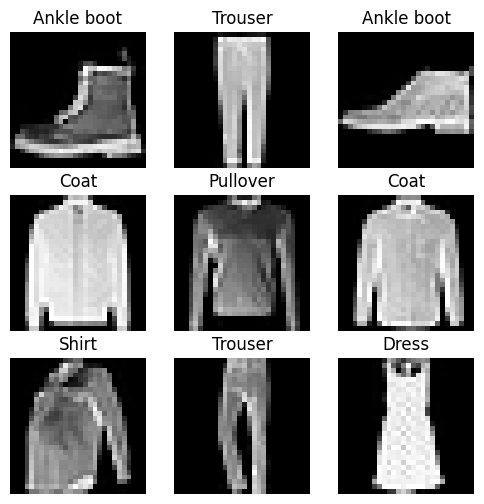

In [ ]:
# Plot random training samples in gray scale:

fig = plt.figure(figsize=(6, 6))

# Grid deminsions
rows = 3
colns = 3

for i in range(1, rows * colns + 1):
  img_id = torch.randint(0, len(train), size=[1]).item() # random index
  img, lbl = train[img_id]
  fig.add_subplot(rows, colns, i)
  plt.axis(False)
  plt.title(cloth_classes[lbl])
  plt.imshow(img.squeeze(), cmap="gray")

In [ ]:
# Batch size hyperparameter:
BATCH_SIZE = 32

# Convert the datasets into mini-batches:
train_batch = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_batch = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [ ]:
# Print details about the loaders:
print(f"Length of train batch: {len(train_batch)}")
print(f"Length of train batch: {len(test_batch)}")

Length of train batch: 1875
Length of train batch: 313


In [ ]:
# Check the training dataloaders size:
train_features_batch, train_labels_batch = next(iter(train_batch))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [ ]:
# Create the model:

class Clothes_Classifier_Model(nn.Module):
  def __init__(self, input_shape, output_shape, hidden_units):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(), # input as vector form
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    """Forward Pass"""
    return self.layers(x)


In [ ]:
# Setup the model and device agnostic code:
device = "cuda" if torch.cuda.is_available() else "cpu"
Clothes_Classifier = Clothes_Classifier_Model(input_shape=784, output_shape=len(cloth_classes), hidden_units=10)
Clothes_Classifier.to(device)


Clothes_Classifier_Model(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
# Setup Loss function and optimizer:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=Clothes_Classifier.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(42)

# Epochs:
epochs = 3

train_loss_rate = []
test_loss_rate = []
training_time = []

# Creat training and testing loop:
for epoch in range(epochs):

  start_timer = timeit.default_timer() # start the timer
  average_train_loss = 0.0

  # Loop through the batches
  for batch, (X, y) in enumerate(train_batch):

    # Train mode
    Clothes_Classifier.train()

    # Forward pass
    train_pred = Clothes_Classifier(X.to(device))

    # Calculate the loss per batch:
    train_loss = loss_fn(train_pred, y.to(device))
    average_train_loss += train_loss.item() # add the loss per epoch through the batch

    # Optimizer zero grad:
    optimizer.zero_grad()

    # Loss backward:
    train_loss.backward()

    # Optimizer step:
    optimizer.step()

    # Divide total train loss by length of training dataloader (average loss per batch per the epoch)
  average_train_loss /= len(train_batch)

  # Testing Loop:
  average_test_loss = 0.0

  Clothes_Classifier.eval()
  with torch.inference_mode():
    for X, y in test_batch:

      # Forward pass:
      test_pred = Clothes_Classifier(X.to(device))

      # Calculate the test loss:
      test_loss = loss_fn(test_pred, y.to(device))

      average_test_loss += test_loss.item()

    average_test_loss /= len(test_batch)

  end_timer = timeit.default_timer() # end the timer

  training_epoch_duration = end_timer - start_timer

  print(f"Epoch: {epoch + 1} | Train loss: {train_loss} | Test loss: {test_loss} | Time: {training_epoch_duration}")

  # Append the results
  train_loss_rate.append(average_train_loss)
  test_loss_rate.append(average_test_loss)
  training_time.append(training_epoch_duration)

Epoch: 1 | Train loss: 0.46309271454811096 | Test loss: 0.4244297444820404 | Time: 14.258040176999998
Epoch: 2 | Train loss: 0.5805755853652954 | Test loss: 0.3896171450614929 | Time: 14.682446096999996
Epoch: 3 | Train loss: 0.3691590428352356 | Test loss: 0.3442694842815399 | Time: 8.64417829300001


<ipython-input-12-1a27c2b2f4ed>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


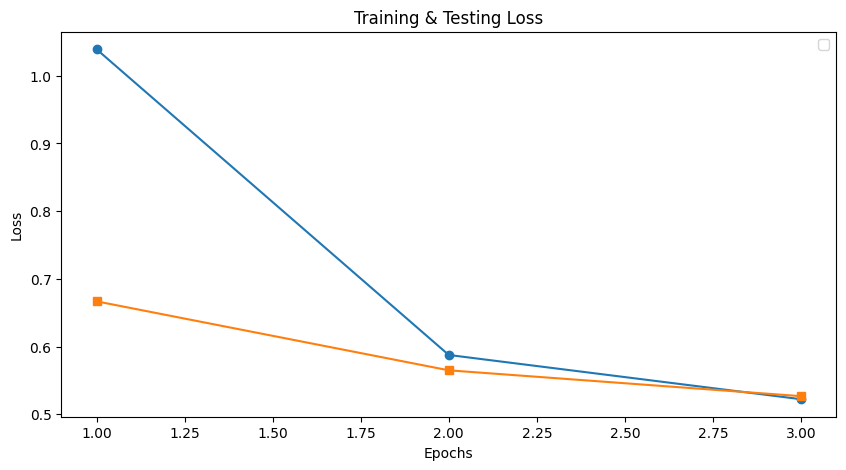

In [ ]:
# plot the Training and the testing loss:

epochs = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_rate, marker="o")
plt.plot(epochs, test_loss_rate, marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Testing Loss")
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Saving the model:
MODEL_NAME = "Clothes_Classifier_Model_state_dict.pth"
DIR = Path("Models")
DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = DIR/MODEL_NAME # Save directory

torch.save(obj=Clothes_Classifier.state_dict(), f=MODEL_SAVE_PATH)